In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import caffe
import os
import lmdb
import cv2

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

local_model_path = '../models'
# local_net_path = '../net/nado_flow'
# local_data_path = '../data_motion'
local_data_path = '../data/data_flow_norm_rep'
# deploy_proto = os.path.join(local_net_path, 'deploy.prototxt')
# mean_data = os.path.join(local_data_path, 'ratsi_mean.binaryproto')

# load labels
labels_file = os.path.join(local_data_path, 'labels.txt')
labels = np.loadtxt(labels_file, str, delimiter='\t')

In [2]:
# model_file = '/home/malte/Install/C3D/C3D-v1.1/examples/c3d_ucf101_training/conv3d_deepnetA_sport1m_iter_1900000.caffemodel'
# netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vidcaf_motion/c3d_sports1m_original.prototxt'

# weights = '/home/malte/Documents/Results/2017-03-13_VidCaf_motion/exp13/vidcaf_motion_iter_3316.caffemodel'
# netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vidcaf_motion/deploy_2s.prototxt'

# weights = '/home/malte/Documents/Results/2017-03-17_VGG_VidCaf_SpatFusion/exp03/gaussian__blr_0.1__wd_5e-3/vgg_vidcaf_2stream_iter_1280.caffemodel'
# netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vgg_vidcaf_2stream/deploy.prototxt'

# netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vgg-m-flow/deploy_original.prototxt'
# weights = '/home/malte/rbr_cnn/rtracker_caffe/net/vgg-m-flow/two_stream_temporal_sp1_v1.caffemodel'

netproto = '/home/malte/rbr_cnn/rtracker_caffe/net/vgg-m-2048/deploy.prototxt'
weights = '/home/malte/Documents/Results/2017-03-15_VGG-M/exp06/vgg-m-2048_iter_1292.caffemodel'

caffe.set_mode_cpu()
net = caffe.Net(netproto, weights, caffe.TEST)

In [2]:
# retrieve a model from the server
# model_file = 'caffe_cweight_iter_45000.caffemodel'
model_file = 'nado_flow_iter_10000.caffemodel'
# os.system("scp dijkstra:rbr_cnn/rtracker_caffe/models/{} {}".format(model_file, os.path.join(local_model_path, model_file)))

local_model_file = os.path.join(local_model_path, model_file)
if os.path.isfile(local_model_file):
    print 'Model found.'
else:
    print 'Could not locate model.'
    
    
# load the model
caffe.set_mode_cpu()

model_def = deploy_proto
model_weights = local_model_file

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

Model found.


In [3]:
# load the mean image for subtraction
blob = caffe.proto.caffe_pb2.BlobProto()
mudata = open( mean_data , 'rb' ).read()
blob.ParseFromString(mudata)
mu = np.array( caffe.io.blobproto_to_array(blob) )
mu = mu.mean(-1).mean(-1).mean(-1)  # average over pixels to obtain the mean pixel value

# we used mu = 115 during fine tuning of imagenet:
mu = np.array([115., 115., 115.])

print 'mean-subtracted values:', zip('G', mu)

NameError: name 'mean_data' is not defined

In [5]:
input_name = 'data'

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({input_name: net.blobs[input_name].data.shape})

transformer.set_transpose(input_name, (2,0,1))  # move image channels to outermost dimension
# transformer.set_mean(input_name, np.array([40, 40, 40])/255.)    # subtract the dataset-mean value in each channel
transformer.set_mean(input_name, np.array([104, 104, 104])/255.)    # subtract the dataset-mean value in each channel
transformer.set_raw_scale(input_name, 255.)      # rescale from [0, 1] to [0, 255]
# transformer.set_channel_swap('data', None)

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
# net.blobs['data'].reshape(1, 256, 256, 1)  # image size is 227x227

In [26]:
lmdb_path = os.path.join(local_data_path, 'ratsi_test_lmdb_flow')
lmdb_env = lmdb.open(lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe.proto.caffe_pb2.Datum()
lmdb_cursor.first()
(key, value) = lmdb_cursor.item()

datum.ParseFromString(value)
label = datum.label

if datum.encoded:
    file_bytes = np.asarray(bytearray(datum.data), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_UNCHANGED)
    print img.shape
    #img = img.transpose(2,0,1)
else:
    img = caffe.io.datum_to_array(datum)

lmdb_env.close()

(64, 64, 3)


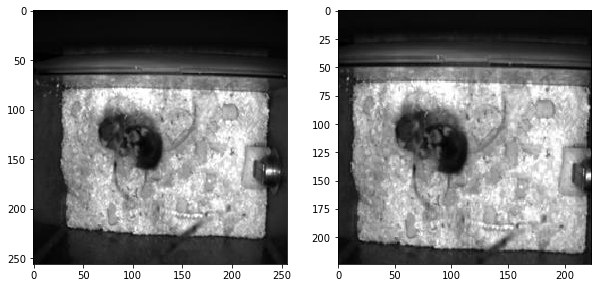

In [7]:
# img = caffe.io.load_image('/home/malte/datasets/RatSI/video_frames/Observation04/frame_00000180.jpg', color=True)
img = caffe.io.load_image('/home/malte/datasets/CRIM13/video_frames/110508_A22_Block16_C57ma1_t/frame_00000180.jpg', color=True)

# crop
w, h = transformer.inputs[input_name][2:]
h_off = (img.shape[0] - h)/2
w_off = (img.shape[1] - w)/2
img_crop = img[h_off:h+h_off, w_off:w+w_off, :].copy()

transformed_image = transformer.preprocess(input_name, img_crop)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img.squeeze())

if transformed_image.ndim > 2:
    axs[1].imshow(transformed_image[2, :, :])
else:
    axs[1].imshow(transformed_image.squeeze())

In [8]:
# copy the image data into the memory allocated for the net
net.blobs[input_name].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax(), labels[output_prob.argmax()]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'top 5 probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

predicted class is: 2 Following
top 5 probabilities and labels:


[(0.71988171, 'Following'),
 (0.18995111, 'Contact'),
 (0.077273659, 'Moving away'),
 (0.012805264, 'Approaching'),
 (6.7351786e-05, 'Solitary')]

---

### Exploring layers

In [9]:
# for each layer, show the output shape
print 'Layer output shapes:'
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)
    
print
print 'Layer parameter shapes:'
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

Layer output shapes:
data	(1, 3, 224, 224)
conv1	(1, 96, 109, 109)
norm1	(1, 96, 109, 109)
pool1	(1, 96, 54, 54)
conv2	(1, 256, 26, 26)
norm2	(1, 256, 26, 26)
pool2	(1, 256, 13, 13)
conv3	(1, 512, 13, 13)
conv4	(1, 512, 13, 13)
conv5	(1, 256, 13, 13)
pool5	(1, 256, 6, 6)
fc6	(1, 2048)
fc7	(1, 2048)
fc8	(1, 6)
prob	(1, 6)

Layer parameter shapes:
conv1	(96, 3, 7, 7) (96,)
conv2	(256, 96, 5, 5) (256,)
conv3	(512, 256, 3, 3) (512,)
conv4	(512, 512, 3, 3) (512,)
conv5_ratsi	(256, 512, 3, 3) (256,)
fc6_ratsi	(2048, 9216) (2048,)
fc7_ratsi	(2048, 2048) (2048,)
fc8_ratsi	(6, 2048) (6,)


(140, 672)


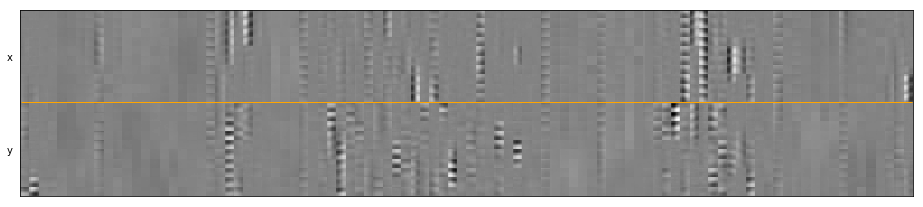

In [73]:
def vis_temporal_channels(data, spatial_mean=False):
    
    if spatial_mean:
        data = data.mean(axis=3).mean(axis=2).T
    
        data_alt = np.empty(data.shape, data.dtype)
        data_alt[::2] = data[:data.shape[0]/2]
        data_alt[1::2] = data[data.shape[0]/2:]
        
        data = data_alt
    else:       
        data_alt = np.empty((data.shape[1]*data.shape[3], data.shape[0] * data.shape[2]), data.dtype)
        K = data.shape[2]
        L = data.shape[1]
        
        for flt in range(data.shape[0]):
            for l in range(L/2):
                # x
                data_alt[l*K:(l+1)*K, flt*K:(flt+1)*K] = data[flt, l*2, :, :]
                # y
                data_alt[(l+L/2)*K:(l+L/2+1)*K, flt*K:(flt+1)*K] = data[flt, l*2+1, :, :]
        
        data = data_alt
    
    print data.shape
    plt.figure(figsize=(16,8))
    plt.imshow(data); #plt.axis('off')
    
    plt.hlines(data.shape[0]/2-1.5, 0, data.shape[1]-1, linewidth=1, colors='orange')
    
    ax = plt.gca()
    ax.set_yticks([data.shape[0]/4-1, 3*data.shape[0]/4-1])
    ax.set_yticklabels(['x','y'])
    ax.tick_params('both', labelleft=True, left=False, bottom=False, labelbottom=False)
    
    
filters = net.params['conv1'][0].data
vis_temporal_channels(filters, spatial_mean=False)

In [10]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data.squeeze()); plt.axis('off')

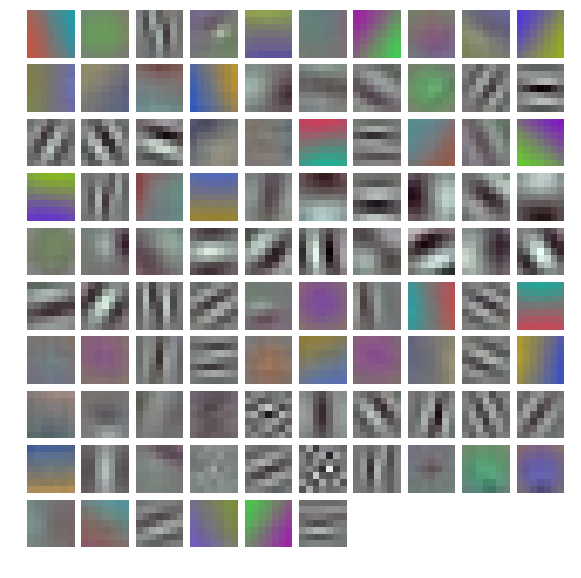

In [17]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

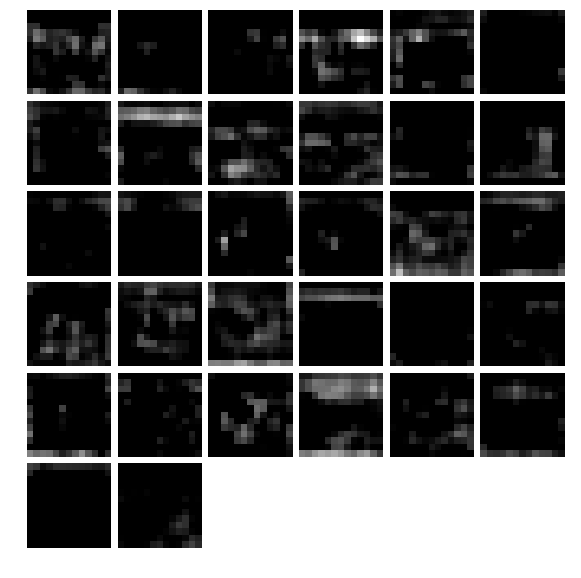

In [35]:
feat = net.blobs['conv4'].data[0]
vis_square(feat[32:64, :])

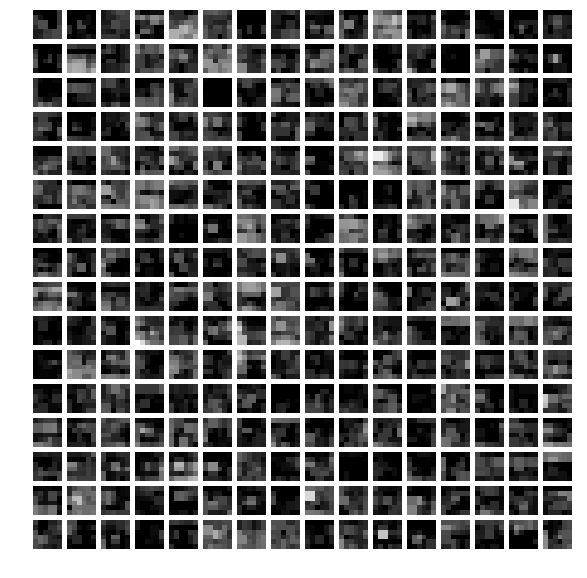

In [22]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

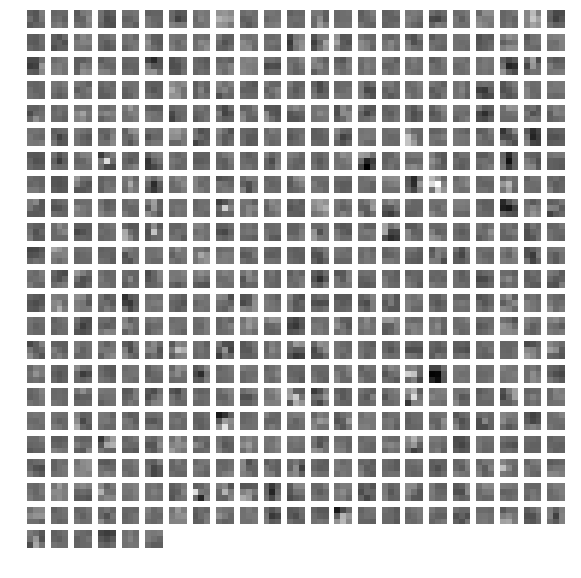

In [15]:
filters = net.params['conv3'][0].data
vis_square(filters.transpose(0, 2, 3, 1)[:,:,:,1])